## Cumputer Vision
### Module 2. Image segmentation and correspondence problems
Anastasiia Kasprova

Link to Google Colab: https://colab.research.google.com/drive/1rykp0whc8U_INYemMCfCM31oN4wy7Lqn

### Task 2.6: Implement Patch-Match Algorithm

#### Patch-Match Algorithm

    1. Initialize pixel with random patch offset
    2. Check whether neighbors have better patch offsets
    3. Search in the concentric radius around the current offsets
    4. Go to step 2 until converge.

In [13]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
#from google.colab.patches import cv2_imshow
import math
import sys
import time
np.set_printoptions(threshold=sys.maxsize)

In [14]:
#image preprocessing: downscale, normalization
def image_preprocessing(image, rescale_coefiecient = 0.25):
    """
    Resize initial image to the size of 'rescale' and normalize the intensity to be in the range (0,1)
    Input: image - numpy array
           rescale - size of output image
    Output: numpy array 
    """
    #resize image
    shape = np.int32(image.shape[1]*rescale_coefiecient), np.int32(image.shape[0]*rescale_coefiecient)
    img = cv2.resize(image,shape)
    #normalize image
    img = (img/255).astype(np.float32)
    
    return img

In [15]:
def patch_distance(a, b, A_padding, B, patch_size):
    """
    Function to calculate the distance (dissimilarity) between 2 patches.
    Input:
        a - patch coordinate in image A: numpy array of x,y coordinates
        b - nearest neighbour of 'a' in image B: numpy array x,y coordinates 
        A_padding - image A with added paddings: numpy array
        B - image B: numpy array
    Output:
        distance - matrix of dissimilarity between 2 patches, calculated as a sum of differences of squares
        
    """
    #define padding
    padding = patch_size//2
    
    #get patches based on the coordinates of top left corner
    patch_a = A_padding[a[0]:a[0]+patch_size, a[1]:a[1]+patch_size, :]
    patch_b = B[b[0]-padding:b[0]+padding+1, b[1]-padding:b[1]+padding+1, :]
    
    #calculate the distance between 2 patches as a sum of differences of squares
    distance = np.sum(np.square(np.nan_to_num(patch_b - patch_a)))
    
    return distance

In [16]:
def initialization(A, B, patch_size):
    """
    The nearest-neighbor ﬁeld can be initialized either by assigning 
    random values to the ﬁeld, or by using prior information. 
    When initializing with random offsets, we use independent uniform samples 
    across the full range of image B. 
    
    This function is devoted to random assignments of the patches.
    
    Input: 
        A - image A: numpy array
        B - image B: numpy array
        patch_size - patch size: integer
    Output: 
        f - matrix of values of offsets: array with dimensions of A
        distance - matrix of distance values between patches a and b
        A_padding - image A with added paddings: numpy array
        
    
    """
    
    #find dimentions of A and B
    A_hight = A.shape[0]
    A_width = A.shape[1]   
    B_hight = B.shape[0]
    B_width = B.shape[1]
    
    #define padding of A and B
    padding = patch_size // 2 
    
    #generate A_hight x A_width (number) possible values of indexes in i and j directions
    random_B_x = np.random.randint(padding, B_hight-padding, [A_hight, A_width])
    random_B_y = np.random.randint(padding, B_width-padding, [A_hight, A_width])
    
    #initialize A_padding 3-dimention matrix  with padding having nan values inside
    A_padding = np.ones([A_hight+padding*2, A_width+padding*2, 3]) * np.nan
    # fullfil A_padding with values corresponding to A leaving padding from each size
    A_padding[padding:A_hight+padding, padding:A_width+padding, :] = A
    
    #initialize matrix to record the location of the reference patch b in B
    f = np.zeros([A_hight, A_width], dtype=object)
    #initialize matrix to record the distance values
    distance = np.zeros([A_hight, A_width])
    
    
    for i in range(A_hight):
        for j in range(A_width):
            a = np.array([i, j],  dtype=np.int32)
            b = np.array([random_B_x[i, j], random_B_y [i, j]], dtype=np.int32)
            f[i, j] = b
            distance[i, j] = patch_distance(a, b, A_padding, B, patch_size)
    
    return f, distance, A_padding

In [17]:
def propagation(f, a, distance, A_padding, B, patch_size, is_odd):
    """
     The patch checks right and bottom neighbors when n_iteration is even, 
     and left and above neighbors when n_iteration is odd, to see 
     if they will improve the mapping, propagating good matches.
     
     We attempt to improve f(x,y) using the known offsetsof f(x−1,y) and f(x,y−1),
     assuming that the patch offsets are likely to be the same. 
     For example, if there is a good mapping at (x−1,y), 
     we try to use the translation of that mapping one pixel to the right 
     for our mapping at (x,y). 
     
     Let D(v) denote the patch distance (error) between the patch at (x,y) in A 
     and patch (x,y)+v in B. We take the new value for f(x,y) to be the 
     arg min of{D(f(x,y)), D(f(x−1,y)), D(f(x,y−1))}. 
     
     The effect is that if (x,y) has a correct mapping and is in a coherent region R, 
     then all of R below and to the right of (x,y) will be ﬁlled with the correct mapping. 
     Moreover, on even iterations we propagate information up and left 
     by examining offsets in reverse scanorder,using f(x+1,y) and f(x,y+1) 
     as our candidate offsets. 
     
     Input: 
         f - matrix of values of offsets: array with dimensions of A
         a - patch coordinate in image A: numpy array of x,y coordinates
         distance - matrix of distance values between patches a and b
         A_padding - image A with added paddings: numpy array
         B - image B: numpy array
         patch_size - patch size: integer
         is_odd - flag of boolean type, to know if it even/odd iteration
     Output: 
         updated f and distance matricies
         
    
    """
    
    #initial dimentions of A
    A_hight = A_padding.shape[0] - patch_size + 1
    A_width = A_padding.shape[1] - patch_size + 1
    
    #possition of top-left corner of A
    x = a[0]
    y = a[1]
    
    #check the number of iteration: 
    #if it is even - go left till the end of the row and then down to the new row 
    if is_odd == False: 
        #check the value of distance of current, from the right side and down
        d_current = distance[x, y]
        d_right = distance[min(x + 1, A_hight-1), y]
        d_down = distance[x, min(y + 1, A_width-1)]
        #find the index of minimun value of 3
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        #if right value is min then assign the value at that possition in f-matrix to the current element of f-matrix (propagate) as well as distance matrix
        if idx == 1:
            f[x, y] = f[min(x + 1, A_hight-1), y]
            distance[x, y] = patch_distance(a, f[x, y], A_padding, B, patch_size)
        #if down value is min then assign the value at that possition in f-matrix to the current element of f-matrix (propagate) as well as distance matrix
        if idx == 2:
            f[x, y] = f[x, min(y + 1, A_width-1)]
            distance[x, y] = patch_distance(a, f[x, y], A_padding, B, patch_size)
    
    #if it is odd - go left till the end of the row and then up to the new row
    else:       
        d_current = distance[x, y]
        d_left = distance[max(x-1, 0), y]
        d_up = distance[x, max(y-1, 0)]
        
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        
        if idx == 1:
            f[x, y] = f[max(x - 1, 0), y]
            distance[x, y] = patch_distance(a, f[x, y], A_padding, B, patch_size)
        if idx == 2:
            f[x, y] = f[x, max(y - 1, 0)]
            distance[x, y] = patch_distance(a, f[x, y], A_padding, B, patch_size)


In [18]:
def random_search(f, a, distance, A_padding, B, patch_size, alpha=0.5):
    """
    The patch searches randomly for improvements in concentric neighborhoods.
    Let v_0=f(x,y). 
    We attempt to improve f(x,y) by testing a sequence of candidate offsets 
    at an exponentially decreasing distance from v_0: 
        u_i = v_0 + w*alpha^i*R_i
            where R_i - a uniform random in [−1,1]×[−1,1]
                  w - a large maximum search “radius”
                  alpha - a fixed ratio between search window sizes.
    We examine patches for i = 0,1,2,... 
    until the current search radius w*alpha^i is below 1 pixel.
    According to authors of the patch-match method [2]:
        w - max image dimension
        alpha - 0.5
        NB! search window must be clamped to the bounds of B.
    
    Input:
        f - matrix of values of offsets: array with dimensions of A
        a - patch coordinate in image A: numpy array of x,y coordinates
        distance - matrix of distance values between patches a and b
        A_padding - image A with added paddings: numpy array
        B - image B: numpy array
        patch_size - patch size: integer
        alpha - a fixed ratio between search window sizes
    Output:
        updated f and distance matricies
    """
    #position of top-left corner of A
    x = a[0]
    y = a[1]
    
    #position of top-left corner of B
    b_x = f[x, y][0]
    b_y = f[x, y][1]    
    
    #define padding size
    padding = patch_size // 2
    
    #SEARCH WINDOW
    #find max dimentions of B
    B_hight = B.shape[0]
    B_width = B.shape[1]
    w = max(B_hight,B_width)
    #define an initial value of a  power to start with
    #320*0.5**4 = 20 pixels, 320*0.5**9 = 0.625
    i = 4
    #size of search window
    search_window = w*alpha**i

    #examine patches for i = 0,1,2,... 
    #until the current search radius w*alpha^i is below 1 pixel
    while search_window > 1:
        #find uniform random R_i in x and y dimentions
        R_x = np.random.randint(-1, 1)
        R_y = np.random.randint(-1, 1)
        
        random_b_x = b_x + R_x*search_window
        random_b_y = b_y + R_y*search_window
        
        #check if random_b_x/random_b_y is in range of possible values. if not - reassign it to max or min possible
        if random_b_x < padding:
            random_b_x = padding
        elif random_b_x > (B_width - padding):
            random_b_x = (B_width - padding)
                
        if random_b_y < padding:
            random_b_y = padding
        elif random_b_y > (B_hight - padding):
            random_b_y = (B_hight - padding)    

        b_random = np.array([random_b_x, random_b_y],  dtype=np.int32)
        #find the new distance value usining random search
        distance_rs = patch_distance(a, b_random, A_padding, B, patch_size)
        #compare the new distance value with the one in the distance matrix
        if distance_rs < distance[x, y]:
            #if the new value is smaller (patches are more simmilar) - update daistance and patch location matrices
            distance[x, y] = distance_rs
            f[x, y] = b_random
        i += 1
        search_window = w*alpha**i


In [19]:
def nearest_neighbors_field(img_A, img_B, patch_size, n_iterations):
    """
    Algorithm for computing patch correspondences.
    Initially, the nearest-neighbor ﬁeld is ﬁlled with random offsets. 
    Next, an iterative update process is applied to the NNF, 
    in which good patch offsets are propagated to adjacent pixels, 
    followed by random search in the neighborhood of the best offset found so far. 
    
    Input: 
        img_A - image A: numpy array
        img_B - image B: numpy array
        patch_size - patch size: integer
        n_iterations - number of iteration for algorithm: integer (~5)
    Output:     
        f - updated matrix of values of offsets: array with dimensions of A
    
    """
    
    A_hight = img_A.shape[0]
    A_width = img_A.shape[1]
    
    f, distance, padding = initialization(img_A, img_B, patch_size)
    
    for n in range(1, n_iterations+1):
        if n % 2 != 0:
            for i in range(A_hight):
                for j in range(A_width):
                    a = np.array([i, j])
                    propagation(f, a, distance, padding, img_B, patch_size, True)
                    random_search(f, a, distance, padding, img_B, patch_size)
        else:
            for i in range(A_hight-1, -1, -1):
                for j in range(A_width-1, -1, -1):
                    a = np.array([i, j])
                    propagation(f, a, distance, padding, img_B, patch_size, False)
                    random_search(f, a, distance, padding, img_B, patch_size)
    return f

In [20]:
#Initialization

#define paramenters
patch_size = 7
n_iterations = 1
rescale_coeficient = 0.25

#read images
img_A = cv2.imread("../../images/correspondence/frames/v001.jpg")
img_A = image_preprocessing(img_A, rescale_coefiecient=rescale_coeficient)
img_B = cv2.imread("../../images/correspondence/frames/v010.jpg")
img_B = image_preprocessing(img_B, rescale_coefiecient=rescale_coeficient)

#find f
start = time.time()
f = nearest_neighbors_field(img_A, img_B, patch_size, n_iterations)
end = time.time()

print("Execution time: ",round((end - start),2), "sec")
print("Shape of image A: ", img_A.shape)
print("Shape of image B: ", img_B.shape)
print("Patch size: ", patch_size,'x', patch_size)
print("Number of iterations: ", n_iterations)

Execution time:  22.37 sec
Shape of image A:  (180, 320, 3)
Shape of image B:  (180, 320, 3)
Patch size:  7 x 7
Number of iterations:  1


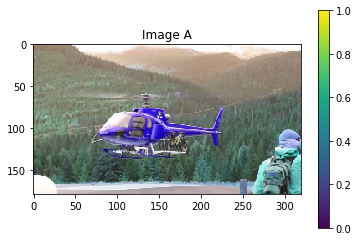

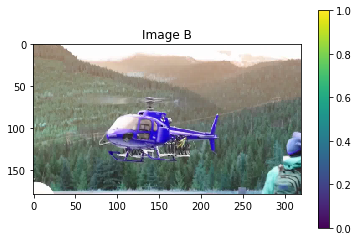

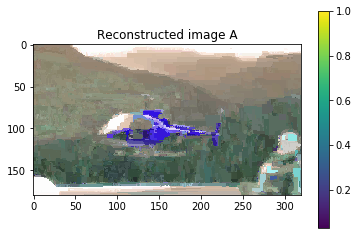

In [21]:
#visualization
img_A_new = np.zeros_like(img_A)
for i in range(img_A.shape[0]):
    for j in range(img_A.shape[1]):
        img_A_new[i,j,:] = img_B[f[i, j][0], f[i, j][1], :]

plt.figure(1)
plt.imshow(img_A)
plt.colorbar()
plt.title("Image A")

plt.figure(2)
plt.imshow(img_B)
plt.colorbar()
plt.title("Image B")

plt.figure(3)
plt.imshow(img_A_new)
plt.colorbar()
plt.title("Reconstructed image A")
plt.show()

#### References:
1. https://www.youtube.com/watch?v=o1G9S-MvFos
2. https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf
3. file:///D:/Studies/UCU_MSc/CV_2019/Module2_Day2.pdf lecture notes
4. https://github.com/MingtaoGuo/PatchMatch/blob/master/PatchMatch.py inspired